# Team-reasoning in HiLo
This notebook implements a simulation of the hilo game using mesa. In the simulation, agents, which are either team-reasoners or not, are randomly assigned other players, with whom they play hilo. The players collected utilities are saved and displayed at the end of the model.

In [1]:
# !pip install nashpy==0.0.20


# game-theoretic:
import nashpy as nash

# mesa:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

#standards:
import numpy as np
import tqdm

# graphics:
import seaborn as sns
import matplotlib.pyplot as plt

# code formatting:
%load_ext nb_black


<IPython.core.display.Javascript object>

We define the high-low-game using the syntax provided by nashpy:

In [2]:
A = np.array([[2, 0], [0, 1]])
game = nash.Game(A, A)

sigma_a = [0.,1.]
sigma_b = [0.5,.5]
game[sigma_a, sigma_b] # check exp. utility for two strategies.


array([0.5, 0.5])

<IPython.core.display.Javascript object>

In [3]:
def random_argmax(b):  # argmax with tiebreaking.
    return np.random.choice(np.flatnonzero(b == np.max(b)))


class MyAgent(Agent):
    """ """

    def __init__(self, unique_id, model, team_reasoner=False):
        super().__init__(unique_id, model)

        self.team_reasoner = team_reasoner
        self.alive = True
        self.gathered_utility = 0

    def step(self):
        #         The agent's step will go here.
        other_player = self.random.choice(self.model.schedule.agents)

        #         print(self.model.game)
        choices = [
            self.reason(player.team_reasoner, player.model.game)
            for player in [self, other_player]
        ]

        payoff = self.model.game[list(choices[0]), list(choices[1])]
        self.gathered_utility += payoff[0]
        pass

    def reason(self, team_reasoner, game):
        if team_reasoner == True:
            if np.random.rand() < 0.6:
                choice = random_argmax([1, 0])
                strat = np.zeros(2)
                strat[choice] = 1
                return strat
            else:
                choice = random_argmax([0.5, 0.5])
                strat = np.zeros(2)
                strat[choice] = 1
                return strat
        else:
            choice = random_argmax([0.5, 0.5])
            strat = np.zeros(2)
            strat[choice] = 1
            return strat


class MyModel(Model):
    """"""

    def __init__(self, proportion_team_reasoners, n_agents, game):
        super().__init__()

        self.num_agents = n_agents
        self.schedule = RandomActivation(self)
        self.game = game

        team_reason_until = int(proportion_team_reasoners * n_agents)
        for ix, i in enumerate(range(self.num_agents)):
            if ix < team_reason_until:
                a = MyAgent(unique_id=i, model=self, team_reasoner=True)
            else:
                a = MyAgent(unique_id=i, model=self, team_reasoner=False)
            self.schedule.add(a)

        agent_reporters = {
            "team_reasoner": lambda a: getattr(a, "team_reasoner", None),
            "gathered_utility": lambda a: getattr(a, "gathered_utility", None),
            "alive": lambda a: getattr(a, "alive", None),
        }

        model_reporters = {}

        self.datacollector = DataCollector(
            model_reporters=model_reporters, agent_reporters=agent_reporters
        )

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)


model = MyModel(proportion_team_reasoners=0.4, n_agents=200, game=nash.Game(A, A))

for t in tqdm.tqdm_notebook(range(100)):
    model.step()

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:85: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [4]:
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

<IPython.core.display.Javascript object>

In [5]:
agent_df

team_reasoner  gathered_utility  alive
Step AgentID                                        
1    0                 True               0.0   True
     1                 True               0.0   True
     2                 True               2.0   True
     3                 True               1.0   True
     4                 True               0.0   True
...                     ...               ...    ...
100  195              False              87.0   True
     196              False              84.0   True
     197              False              85.0   True
     198              False              70.0   True
     199              False              97.0   True

[20000 rows x 3 columns]

<IPython.core.display.Javascript object>

In [6]:
agent_df = agent_df.reset_index()

<IPython.core.display.Javascript object>

Text(0.0, 1.0, 'Achieved utility in hilo after 100 iterations')

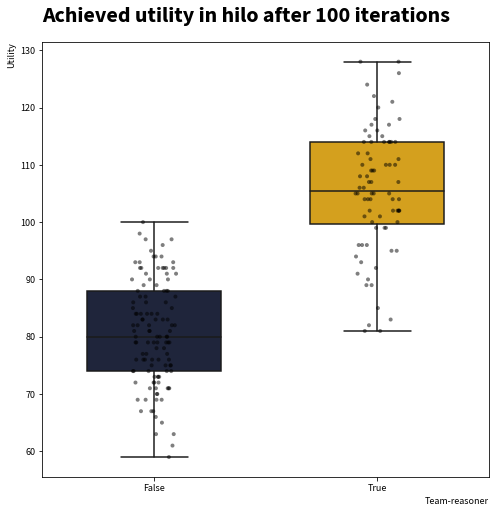

<IPython.core.display.Javascript object>

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.style.use("opinions.mplstyle")

to_plot = agent_df[agent_df["Step"] == np.max(agent_df["Step"])]

# Plot the orbital period with horizontal boxes
sns.boxplot(
    x="team_reasoner",
    y="gathered_utility",
    data=to_plot,
    whis=[0, 100],
    width=0.6,
    palette=["#1a2340", "#f2ad00"],
)

# Add in points to show each observation
sns.stripplot(
    x="team_reasoner",
    y="gathered_utility",
    data=to_plot,
    size=4,
    color="black",
    linewidth=0,
    alpha=0.5,
)

plt.xlabel("Team-reasoner")
plt.ylabel("Utility")
plt.title(
    "Achieved utility in hilo after " + str(np.max(agent_df["Step"])) + " iterations"
)